In [2]:
import os
import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import _gradient_boosting
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions_pipe_testing import *
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *
from sklearn.preprocessing import LabelEncoder
from helper_functions_KP import *
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

In [3]:
#Editable Variables
multi_files=False #set to false if you just want to set one  prot_abund_file
in_dir="Input_data/Proteomic data/Abundance2/"
prot_abund_file='Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
NP_filepath='Input_data/NPs/NP_Database.xlsx'
controls_file='Input_data/Proteomic data/controls_combined.xlsx'
uniprot_filepath='Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
NSPfilePath='Input_data/NetSurfP_data/Combined.xlsx'
# take files in_dir and combine then into one pandas df (raw_MS_data) ###USE when combining multiple datasets####
files = os.listdir(in_dir)
print(files)
if multi_files == True:
    for i,f in enumerate(files):
        print(i)
        if i==0:
            raw_MS_data=pd.read_excel(in_dir+f,header=0)
            # print(raw_MS_data)
            raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'],var_name='Sample_num', value_name='Abundance')
            print('BALF',raw_MS_data.shape)
        else:
            print(i)
            temp = pd.read_excel(in_dir+f,header=0)
            temp = pd.melt(temp, id_vars=['Entry'],var_name='Sample_num', value_name='Abundance')
            print('Bovine',temp.shape)
            # print(temp)
            # print(temp)
            raw_MS_data2=pd.concat([raw_MS_data,temp])
            print('merge',raw_MS_data2.shape)
            # print('did it')
else:
    raw_MS_data2=pd.read_excel(prot_abund_file,header=0)
# raw_MS_data2
# melt the df to make it an accession number, NPUNID, Abundance dataset
# raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'],var_name='Sample_num', value_name='Abundance')


['NormBALFsamples.xlsx', 'Norm_Intensity _all20230403.xlsx']


In [5]:
(raw_MS_data2['Abundance']==0).sum()

25738

#Instructions for the pipeline Requires two inputs for training: - Mass spec data with corresponding NP surface characteristics and experimental conditions (time, concentration) - NetsurfP and Biopython data that has been precalculated - X characteristics to predict
pipeline Take mass spec spreadsheet Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration Merge with Proteome data to get file that has Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration,Mass,Length,Sequence Calculate protein features using biopython Merge with NSP data to get all protein features
Split into X and Y dataset with Entries as labels

In [4]:
#Editable Variables
multi_files=False #set to false if you just want to set one  prot_abund_file
in_dir="Input_data/Proteomic data/Abundance2/"
prot_abund_file='Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
NP_filepath='Input_data/NPs/NP_Database.xlsx'
controls_file='Input_data/Proteomic data/controls_combined.xlsx'
uniprot_filepath='Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
NSPfilePath='Input_data/NetSurfP_data/Combined.xlsx'
id='allnps_meltb4join'
# take files in_dir and combine then into one pandas df (raw_MS_data) ###USE when combining multiple datasets####
# melt the df to make it an accession number, NPUNID, Abundance dataset before combining
files = os.listdir(in_dir)
if multi_files == True:
    for i,f in enumerate(files):
        if i==0:
            raw_MS_data=pd.read_excel(in_dir+f,header=0)
            # print(raw_MS_data)
            raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'],var_name='Sample_num', value_name='Abundance')

        else:

            temp = pd.read_excel(in_dir+f,header=0)
            temp = pd.melt(temp, id_vars=['Entry'],var_name='Sample_num', value_name='Abundance')

            raw_MS_data=pd.concat([raw_MS_data,temp])

else:
    raw_MS_data=pd.read_excel(prot_abund_file,header=0)
    raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'],var_name='Sample_num', value_name='Abundance')
#remove prots that were added due to merge
raw_MS_data=raw_MS_data.dropna()
###Bring in controls (MS data for serums)##
controls=pd.read_excel(controls_file,header=0)
MS_data_controls = pd.merge(raw_MS_data,controls,how='left', on='Entry')
###Bring in Uniprot_data,NSPdata and NP data##
uniprot_dat=pd.read_excel(uniprot_filepath,header=0)
NSP_data=pd.read_excel(NSPfilePath)
###Bring in NP data and merge to get complete NP dataset###
NPUNdata=pd.read_excel(NP_filepath,header=0,sheet_name='NPUNID')
NPprop=pd.read_excel(NP_filepath,header=0,sheet_name='NP_Props')
NPdata=pd.merge(NPUNdata,NPprop,how="left",on='NPID')
NPdata.dropna(inplace=True)
#calculate Enrichment
#####MAYBE add binning here to keep negative results and improve capapbilities######
# MS_data_controls['Enrichment']= np.log2(MS_data_controls['Abundance']/MS_data_controls['Abundance_Controls'])
# MS_data=MS_data_controls.drop(columns=['Abundance','Abundance_Controls'])
#keep abundance Controls
# MS_data=MS_data_controls.drop(columns=['Abundance'])
raw_prop_data=pd.merge(MS_data_controls, uniprot_dat.drop_duplicates(subset=['Entry']), how='left',on='Entry')
Protein_data_complete = pd.merge(raw_prop_data, NSP_data.drop_duplicates(subset=['Entry']),how='left', on='Entry') #merges netsurfp features and biopython features
Protein_data_complete.fillna(0,inplace=True)
#creates new column called asa_sum_normalized which is the asa_sum value divide by the mass of the protein
for df in [Protein_data_complete]:
    for col in ['asa_sum']:
        df[col+'_normalized'] = df[col] / df['Mass']

data_complete= pd.merge(Protein_data_complete,NPdata,how='inner', on='Sample_num')
data_complete.drop(columns=['notes','Notes','NPUNID'],inplace=True)
data_complete.fillna(0,inplace=True)
data_complete= data_complete.replace([-np.inf],'-12')
data_complete=data_complete.replace([np.inf],'12')
#create ordinal variables
# data_complete2=pd.get_dummies(data_complete, columns=['Core Material','Surface_Ligand'])
le=LabelEncoder()
data_complete['Core Material']=le.fit_transform(data_complete['Core Material'])
data_complete['Surface_Ligand']=le.fit_transform(data_complete['Surface_Ligand'])

#set labels (what we are trying to predict) as Enrichment column
# labels=data_complete['Enrichment'].copy()
label_abund=np.ravel(data_complete['Abundance'].copy())
label_abund_df=pd.DataFrame(label_abund)
# label_enrich=np.ravel(data_complete['Enrichment'].copy())
#make it one dimenisional
#drop qualitative, not neccessary, and label columns
#create df without bonus NSP columns (remove total_exposed) There are too sets of features total_exposed and exposed_exposed
to_drop=data_complete.filter(like='total_exposed_')
data_complete.drop(columns=to_drop,inplace=True)
df=data_complete.drop(['Entry','Abundance','Sequence','NPID','Ligands','Protein Source','Sample_num','Unnamed: 5','Raw_FileID'],axis=1)
# df_enrich=data_complete.drop(['Entry','Abundance','Sequence','NPID','Ligands','Protein Source','Sample_num','Unnamed: 5','Raw_FileID'],axis=1)
df.to_excel("Input_data/Save_files/df_"+id+".xlsx")
label_abund_df.to_excel("Input_data/Save_files/label_abund"+id+".xlsx",index=False)
# label_enrich.to_excel("Input_data/Save_files/label_enrich_synth.xlsx")

In [9]:
data = pd.concat((df, label_abund_df), axis=1)
data

,Abundance_Controls,Length,Mass,frac_aa_A,frac_aa_C,frac_aa_D,frac_aa_E,frac_aa_F,frac_aa_G,frac_aa_H,...,Dh_functionalized,Shaken,Centrifuged,ProteinID,NP_incubation Concentration (mg/mL),Incubation Concentration (mg/ml),Corona_Concentration (ug/mg),Incubation Time (minutes),Temperature,0
0,41.344176,607.0,69293.0,0.079077,0.057661,0.065898,0.097199,0.049423,0.028007,0.028007,...,149.0,1,0,1,5.0,4.0,19.211444,30,25,12.564744
1,16.558542,359.0,38419.0,0.097493,0.038997,0.064067,0.050139,0.033426,0.061281,0.030641,...,149.0,1,0,1,5.0,4.0,19.211444,30,25,4.613993
2,0.070561,1236.0,140374.0,0.038026,0.066343,0.046926,0.080906,0.027508,0.076861,0.025081,...,149.0,1,0,1,5.0,4.0,19.211444,30,25,2.752709
3,0.343098,465.0,52347.0,0.064516,0.019355,0.045161,0.075269,0.053763,0.049462,0.012903,...,149.0,1,0,1,5.0,4.0,19.211444,30,25,1.503213
4,12.125543,416.0,46104.0,0.084135,0.014423,0.050481,0.064904,0.055288,0.052885,0.043269,...,149.0,1,0,1,5.0,4.0,19.211444,30,25,3.155554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,0.000000,548.0,57765.0,0.093066,0.060219,0.041971,0.063869,0.032847,0.135036,0.025547,...,229.0,1,0,1,5.0,40.0,59.099292,30,25,0.000000
8516,0.000000,415.0,47231.0,0.091566,0.019277,0.040964,0.067470,0.045783,0.053012,0.024096,...,229.0,1,0,1,5.0,40.0,59.099292,30,25,0.000000
8517,0.000000,193.0,22748.0,0.031088,0.015544,0.056995,0.036269,0.062176,0.036269,0.010363,...,229.0,1,0,1,5.0,40.0,59.099292,30,25,0.000000
8518,0.000000,113.0,12977.0,0.106195,0.026549,0.053097,0.070796,0.026549,0.053097,0.044248,...,229.0,1,0,1,5.0,40.0,59.099292,30,25,0.000000


In [18]:
df_no0 = data_complete[data_complete.Abundance != 0]
df_no0.shape
label_abund2=np.ravel(df_no0['Abundance'].copy())

# label_enrich=np.ravel(data_complete['Enrichment'].copy())
#make it one dimenisional
#drop qualitative, not neccessary, and label columns
#create df without bonus NSP columns (remove total_exposed) There are too sets of features total_exposed and exposed_exposed
to_drop=df_no0.filter(like='total_exposed_')
df_no0.drop(columns=to_drop,inplace=True)
df_no0=df_no0.drop(['Entry','Abundance','Sequence','NPID','Ligands','Protein Source','Sample_num','Unnamed: 5','Raw_FileID'],axis=1)

C:\Users\kmp95\AppData\Local\Temp\ipykernel_10048\673706784.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no0.drop(columns=to_drop,inplace=True)


In [ ]:
df_2=pd.read_excel("Input_data/Save_files/df_synth_RFECV"+id+".xlsx")
df_2.drop(columns=['Unnamed: 0'],inplace=True)
label_df=pd.read_excel("Input_data/Save_files/label_abund_"+id+".xlsx")
label_abund=np.ravel(label_df[0])
print(label_abund.shape)
print(df_2.shape)

C:\Users\kmp95\AppData\Local\Temp\ipykernel_10048\1792883351.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


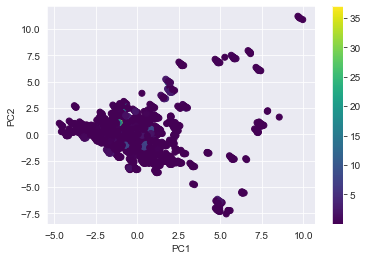

In [48]:
#Run PCA to seee how data differentiates#
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

x=df_2

scaler = StandardScaler()
X_std = scaler.fit_transform(x)
pca= PCA(n_components=5)
x_pca=pca.fit_transform(X_std)

plt.scatter(x_pca[:, 0], x_pca[:, 1], c=label_abund2, cmap='viridis')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('Output_data/PCA'+id+'.png')
plt.show()

In [41]:
x_pca

array([[-1.1127853 ,  1.00194061,  0.61474609,  1.91083472, -2.90927747],
       [ 0.51730506, -1.08138284, -1.1141686 , -0.30577492, -2.95302479],
       [ 2.89366567,  2.51872972,  0.48561381, -0.99484252, -2.74953966],
       ...,
       [-1.3993203 ,  1.9578863 ,  1.69218275,  1.15947841,  0.52929401],
       [-0.58469283,  2.54180318,  1.07949607,  1.12480793,  0.55806057],
       [-1.48749258, -0.02568224,  0.22396238,  2.28955892,  0.49519046]])

In [ ]:
#Remove correlated features (over r2 threshold level) and output reduced dataframe (df2)# ##Maybe use in future##
# corr_matrix = df.corr()
# threshold = 0.8
# correlated_features = set()
#
# for i in range(len(corr_matrix.columns)):
#     for j in range(i):
#         if threshold < abs(corr_matrix.iloc[i, j]) < 1:
#             colname = corr_matrix.columns[i]
#             correlated_features.add(colname)
# correlated_features
# df_2=df.drop(columns=correlated_features)

In [20]:
#use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
step=2
feats=50
estimator=RandomForestRegressor(n_estimators=100)
selector = RFE(estimator, n_features_to_select=feats, step=step)
selector = selector.fit(df_no0, label_abund2)
selector.support_
ranking=selector.ranking_
feat_list = selector.get_feature_names_out()
df_rfe=df_no0[feat_list]
feat_list

array(['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C',
       'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_I', 'frac_aa_N',
       'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_V', 'frac_aa_W',
       'frac_aa_Y', 'molecular_weight', 'instability_index',
       'flexibility_mean', 'isoelectric_point',
       'secondary_structure_fraction_helix',
       'secondary_structure_fraction_turn',
       'secondary_structure_fraction_sheet', 'rsa_std', 'asa_sum',
       'fraction_exposed_exposed_A', 'fraction_exposed_exposed_D',
       'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H',
       'fraction_exposed_exposed_I', 'fraction_exposed_exposed_L',
       'fraction_exposed_exposed_N', 'fraction_exposed_exposed_P',
       'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S',
       'fraction_exposed_exposed_V', 'fraction_exposed_exposed_Y',
       'nsp_secondary_structure_coil', 'nsp_secondary_structure_sheet',
       'nsp_disordered', 'asa_sum_normalized

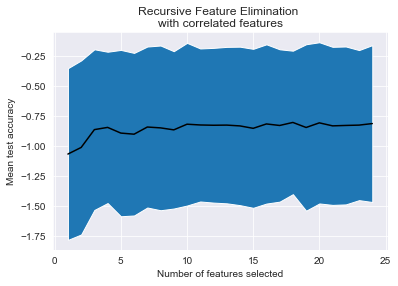

In [22]:
#run Recursive feature elimination with cross validation
from sklearn.model_selection import KFold
id2='dropped_controlAbundance'
step=2
min_feats=5
cv= KFold(n_splits=10)
estimator=RandomForestRegressor(n_estimators=100)
# estimator=Lasso(alpha=.05)
selector = RFECV(estimator=estimator, cv=cv, scoring='neg_mean_squared_error', min_features_to_select=min_feats, step=step)
selector = selector.fit(df_rfe, label_abund2)
selector.support_
feat_list2 = selector.get_feature_names_out()
selected_features= df_rfe.columns[selector.support_]
df_2=df[feat_list2]
df_2.to_excel("Input_data/Save_files/df_RFECV"+id+id2+".xlsx")
rfecv_df=pd.DataFrame(selector.cv_results_)
rfecv_df.to_excel("Output_data/RFECV_results"+id+id2+".xlsx")
# label_abund_df.to_excel("Input_data/Save_files/label_abund_all.xlsx")
n_scores = len(selector.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
x=range(1, n_scores + 1)
y=selector.cv_results_["mean_test_score"]
err=selector.cv_results_["std_test_score"]
plt.plot(x,y,'k-')
plt.fill_between(x,y-err,y+err)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.savefig('Output_data/RFECV45'+id+id2+'.png')
plt.show()

In [25]:
df_2=df_no0[feat_list2]

In [44]:
label_abund2

array([1.25647443e+01, 4.61399290e+00, 2.75270866e+00, ...,
       1.25965620e-03, 4.75909210e-03, 2.22462769e-03])

In [ ]:
#test estimator to see what is the ideal number of estimators
# estimators=np.arange(5,500,5)
# out_name=np.arange(5,500,5)
# # print(out_name)
# scores=[]
# x_train, x_test, y_train, y_test = train_test_split(df_abund, label_abund,
#                                                         test_size=0.2,
#                                                         random_state=42)
#
# for i in range(len(estimators)):
#     rfg = RandomForestRegressor(n_estimators=estimators[i])
#     rfg.fit(x_train, y_train)
#     score=rfg.score(x_test,y_test)
#     scores.append(score)
# a=pd.DataFrame(list(zip(estimators,scores)), columns=['number of estimators','accuracy'])
# a.to_excel("Output_data/estimators_score_abund.xlsx")

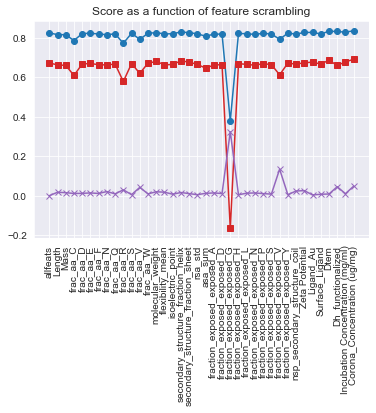

In [33]:
##SCRAM Loss##
#look at loss as a function of feature
# df_2.drop(columns='Abundance_Controls',inplace=True)
feats=[]
r2s=[]
pearson=[]
id2='norm'
test_percent=0.2
label=label_abund2
# frames=['df','df_norm','df_NSP_drop']
# for x,i in enumerate(df_listnew):\
# df_2.drop(columns=['Abundance Controls'],inplace=True)
x_train, x_test, y_train, y_test = train_test_split(df_2,label, test_size = test_percent, random_state=42)
rfr=RandomForestRegressor(n_estimators=150)
rfr.fit(x_train,y_train)
predictions=rfr.predict(x_test)
r2=r2_score(y_test, predictions)
corr,_ = pearsonr(y_test, predictions)
r2s.append(r2)
pearson.append(corr)
feat_import= rfr.feature_importances_
feats.append('allfeats')
feat_import=np.insert(feat_import, [0], 0)
for j in x_test.columns:
    tmp=x_test.copy()
    # print(x_test)
    np.random.shuffle(tmp[j].values)
    scram_score=rfr.score(tmp,y_test)
    predictions=rfr.predict(tmp)
    r2=r2_score(y_test, predictions)
    corr,_ = pearsonr(y_test, predictions)
    r2s.append(r2)
    pearson.append(corr)
    feats.append(j)

a=pd.DataFrame(list(zip(feats, pearson,r2s, feat_import)), columns=['feat', 'pearson','R2', 'importances'])
a.to_excel("Output_data/scram_loss_feats"+id2+id+".xlsx")

fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.plot(feats, pearson, color='tab:blue',marker= 'o')
ax.plot(feats, r2s, color='tab:red',marker='s')
ax.plot(feats, feat_import, color='tab:purple', marker='x')

plt.title('Score as a function of feature scrambling')
plt.savefig('Output_data/RFECV50_FeatScramLoss'+id+'.png', bbox_inches='tight')
plt.show()



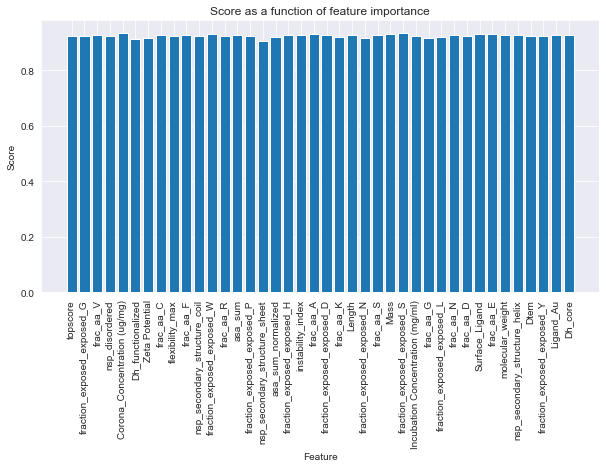

In [24]:
##FEAT DROP NOT Cumulative##
##Fit and predict after dropping the next least loss feature, drop one feature at a time

feats=[]
r2s=[]
pearson=[]
id2='norm'
test_percent=0.4

x_train, x_test, y_train, y_test = train_test_split(df_2,label_abund, test_size = test_percent, random_state=42)

rfr=RandomForestRegressor(n_estimators=150)
rfr.fit(x_train,y_train)
topscore=rfr.score(x_test,y_test)
a=list(zip(rfr.feature_importances_,rfr.feature_names_in_))
a.sort(reverse=True)
col_import=pd.DataFrame(a,columns=['importances','names'])
sorted_cols=col_import['names']
feats.append('topscore')
scores.append(topscore)

#df_3=df_2.copy()
for i in sorted_cols:
    df_3=df_2.copy() #remove if you only want to drop each feature instead of dropping one feature at a time
    df_3.drop(columns=[i],inplace=True)
    x_train, x_test, y_train, y_test = train_test_split(df_3,label_abund, test_size = 0.2, random_state=42)
    rfr.fit(x_train,y_train)
    predictions=rfr.predict(x_test)
    r2=r2_score(y_test, predictions)
    corr,_ = pearsonr(y_test, predictions)
    r2s.append(r2)
    pearson.append(corr)
    feats.append(i)

df_out=pd.DataFrame(list(zip(feats,scores)),columns=['dropped feat','score without feat'])
df_out.to_excel("Output_data/scores_afterdrop"+id+id2+".xlsx")

fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
# Create a bar chart for the first y-axis
ax1.plot(feats, pearson, color='tab:blue')
ax1.set_xlabel('Features')
ax1.set_ylabel('Pearson Correlation', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0,1)

# Create a second y-axis object
ax2 = ax1.twinx()

# Create a line chart for the second y-axis
ax2.plot(feats, r2s, color='tab:red', marker='o')
ax2.set_ylabel('R^2', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0,1)
plt.savefig('Output_data/RFECV50_FeatDropLoss'+id+'.png')
plt.show()

(2737, 36)
(2737, 35)
(2737, 34)
(2737, 33)
(2737, 32)
(2737, 31)
(2737, 30)
(2737, 29)
(2737, 28)
(2737, 27)
(2737, 26)
(2737, 25)
(2737, 24)
(2737, 23)
(2737, 22)
(2737, 21)
(2737, 20)
(2737, 19)
(2737, 18)
(2737, 17)
(2737, 16)
(2737, 15)
(2737, 14)
(2737, 13)
(2737, 12)
(2737, 11)
(2737, 10)
(2737, 9)
(2737, 8)
(2737, 7)
(2737, 6)
(2737, 5)
(2737, 4)
(2737, 3)
(2737, 2)
(2737, 1)


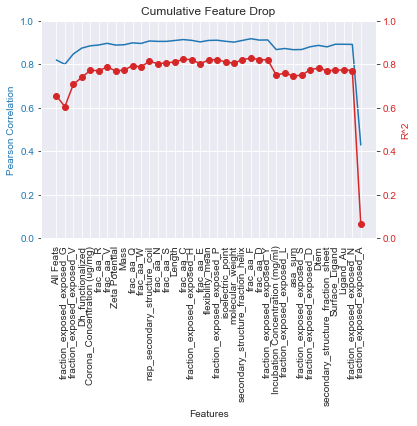

In [42]:
##CUMUlATIVE FEATURE DROP##
##Fit and predict after dropping the next least loss feature, drop one feature at a time cumulative

feats=[]
r2s=[]
pearson=[]
id2='norm'
test_percent=0.3

x_train, x_test, y_train, y_test = train_test_split(df_2,label_abund2, test_size = test_percent, random_state=42)

rfr=RandomForestRegressor(n_estimators=150)
rfr.fit(x_train,y_train)
predictions=rfr.predict(x_test)
r2=r2_score(y_test, predictions)
corr,_ = pearsonr(y_test, predictions)
a=list(zip(rfr.feature_importances_,rfr.feature_names_in_))
a.sort(reverse=True)
col_import=pd.DataFrame(a,columns=['importances','names'])
sorted_cols=col_import['names']
feats.append('All Feats')
r2s.append(r2)
pearson.append(corr)

df_3=df_2.copy()
for i in sorted_cols:
    if i == sorted_cols.iloc[-1]:
        break
    # df_3=df_2.copy() #remove if you only want to drop each feature instead of dropping one feature at a time
    df_3.drop(columns=[i],inplace=True)
    print(df_3.shape)
    x_train, x_test, y_train, y_test = train_test_split(df_3,label_abund2, test_size = test_percent, random_state=42)
    rfr.fit(x_train,y_train)
    predictions=rfr.predict(x_test)
    r2=r2_score(y_test, predictions)
    corr,_ = pearsonr(y_test, predictions)
    r2s.append(r2)
    pearson.append(corr)
    feats.append(i)

df_out=pd.DataFrame(list(zip(feats,pearson,r2s)),columns=['dropped feat','Pearson','r2'])
df_out.to_excel("Output_data/scores_afterdrop_cumulative_reverse"+id+id2+".xlsx")
# Create a figure and axis object
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
# Create a bar chart for the first y-axis
ax1.plot(feats, pearson, color='tab:blue')
ax1.set_xlabel('Features')
ax1.set_ylabel('Pearson Correlation', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0,1)

# Create a second y-axis object
ax2 = ax1.twinx()

# Create a line chart for the second y-axis
ax2.plot(feats, r2s, color='tab:red', marker='o')
ax2.set_ylabel('R^2', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0,1)

# Set the title and display the chart
plt.title('Cumulative Feature Drop')

plt.savefig('Output_data/RFECV50_FeatDropLossCumul'+id+id2+'.png',bbox_inches='tight')
plt.show()
#
# plt.figure(figsize=(10,5))
# plt.bar(feats, scores)
# plt.xlabel('Feature')
# plt.ylabel('Score')
# plt.title('Score after Cumulative Feature Drop')
# plt.xticks(rotation=90)
# plt.savefig('Output_data/RFECV50_FeatDropLossCumul'+id+'.png',bbox_inches='tight')
# plt.show()

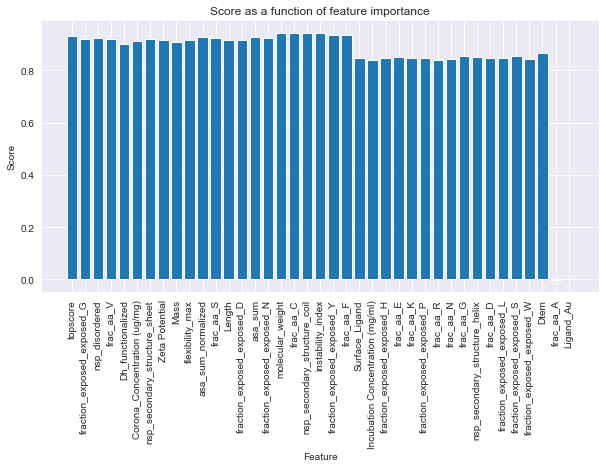

In [23]:
plt.figure(figsize=(10,5))
plt.bar(feats, scores)
plt.xlabel('Feature')
plt.ylabel('Score')
plt.title('Score as a function of feature importance')
plt.xticks(rotation=90)
plt.savefig('Output_data/RFECV50_FeatDropLossCumul'+id+'.png',bbox_inches='tight')
plt.show()

In [ ]:
# plot predictions with prediction accuracies#

In [16]:
#look at pearson correlation of predictions#
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(df_2,label_abund, test_size = 0.2, random_state=42)

rfr=RandomForestRegressor(n_estimators=150)
rfr.fit(x_train,y_train)
predictions=rfr.predict(x_test)
r2=r2_score(y_test, predictions)
corr,_ = pearsonr(y_test, predictions)

print(r2)
print(corr)



0.9407157864634208
0.9718527929283327


In [ ]:
#look at pearson correlation of predictions#
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(df_2,label_abund, test_size = 0.2, random_state=42)

rfr=RandomForestRegressor(n_estimators=150)
rfr.fit(x_train,y_train)
predictions=rfr.predict(x_test)
r2=r2_score(y_test, predictions)
corr,_ = pearsonr(y_test, predictions)

print(r2)
print(corr)



In [25]:
a=np.count_nonzero(label_abund)
b=label_abund.size
a/b*100

32.124413145539904

In [30]:
df_2.drop(columns=['Corona_Concentration (ug/mg)'],inplace=True)
df_2

,Length,Mass,frac_aa_A,frac_aa_C,frac_aa_D,frac_aa_E,frac_aa_F,frac_aa_G,frac_aa_K,frac_aa_N,...,nsp_secondary_structure_helix,nsp_disordered,asa_sum_normalized,Zeta Potential,Ligand_Au,Surface_Ligand,Dtem,Dh_core,Dh_functionalized,Incubation Concentration (mg/ml)
0,607.0,69293.0,0.079077,0.057661,0.065898,0.097199,0.049423,0.028007,0.098847,0.023064,...,0.710,0.043,0.560216,-42.0,0,0,82.0,149.0,149.0,4.0
1,359.0,38419.0,0.097493,0.038997,0.064067,0.050139,0.033426,0.061281,0.041783,0.019499,...,0.120,0.348,0.745338,-42.0,0,0,82.0,149.0,149.0,4.0
2,1236.0,140374.0,0.038026,0.066343,0.046926,0.080906,0.027508,0.076861,0.065534,0.037217,...,0.005,0.019,0.676699,-42.0,0,0,82.0,149.0,149.0,4.0
3,465.0,52347.0,0.064516,0.019355,0.045161,0.075269,0.053763,0.049462,0.068817,0.053763,...,0.241,0.168,0.590988,-42.0,0,0,82.0,149.0,149.0,4.0
4,416.0,46104.0,0.084135,0.014423,0.050481,0.064904,0.055288,0.052885,0.076923,0.055288,...,0.257,0.127,0.578761,-42.0,0,0,82.0,149.0,149.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,548.0,57765.0,0.093066,0.060219,0.041971,0.063869,0.032847,0.135036,0.029197,0.014599,...,0.088,0.356,0.768389,12.0,1,2,98.0,149.0,229.0,40.0
8516,415.0,47231.0,0.091566,0.019277,0.040964,0.067470,0.045783,0.053012,0.036145,0.038554,...,0.337,0.108,0.582805,12.0,1,2,98.0,149.0,229.0,40.0
8517,193.0,22748.0,0.031088,0.015544,0.056995,0.036269,0.062176,0.036269,0.082902,0.062176,...,0.073,0.031,0.549793,12.0,1,2,98.0,149.0,229.0,40.0
8518,113.0,12977.0,0.106195,0.026549,0.053097,0.070796,0.026549,0.053097,0.044248,0.017699,...,0.310,0.142,0.664929,12.0,1,2,98.0,149.0,229.0,40.0
